# Clustering experiment

In this notebook we will try the K-medoids clustering of affiliates healthcare pathways. We will make use of the output of the notebook "Preprocess_raw_data". The algorithm used will be Partitioning Around Medoids (PAM).

### Installations and imports

In [5]:
import numpy as np
import pandas as pd
import os
from kmedoids import pam,KMedoids,silhouette
from sklearn.metrics import silhouette_samples

import subprocess
import sys

import json
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns

### Read the sequences dataset

The affiliates healthcare patwhays are are represented as a dataset of sequences. Each sequence has 7 elements, where each element can be a code value between $[0,2^17]$ represented as an hexadecimal, where 17 is the amount of medical practices to analyze, and 7 is the amount of semesters.

In [6]:
# The main directory to find the preprocessed datasets
base_dir = '../dataset/preprocessed'

In [7]:
target_filename = 'sequences_dataset.csv'

for dirname, _, filenames in os.walk(base_dir):
    if target_filename in filenames:
        filepath = os.path.join(dirname, target_filename)
        print(f"File founded: {filepath}")
        sequences_dataset = pd.read_csv(filepath)
        break  

File founded: ../dataset/preprocessed\sequences_dataset.csv


In [8]:
sequences_dataset

,semester_1,semester_2,semester_3,semester_4,semester_5,semester_6,semester_7
0,8000,0,0,0,C803,0,0
1,C802,0,2,0,E803,0,0
2,0,0,0,80,0,0,80
3,0,0,0,0,8802,0,0
4,0,0,0,0,0,400,0
...,...,...,...,...,...,...,...
4515,0,0,0,D803,0,0,0
4516,0,0,80,0,0,0,0
4517,0,0,0,0,C800,0,0
4518,0,0,C803,80,0,0,0


### Create the dissimilarity matrix

For the PAM algorithm, we need to calculate a dissimilarity matrix. Each element $(i,j)$ in the matrix represt the rate of dissimilarity between a sequence $i$ and $j$. The matrix will be alredy precomputed. Because of this, the $\texttt{PROCESS}$ flag will be set to False. In case you want to reprocess it, set it to True.

In [10]:
input_dir = '../dataset/preprocessed/sequences_dataset.csv'
output_dir = '../dataset/preprocessed/dissimilarity_matrix.csv'

PROCESS = True
if PROCESS:
    subprocess.run(['Rscript', '../functions/optimal_matching.R', input_dir, output_dir], check=True)

In [11]:
diss_matrix = pd.read_csv(output_dir).iloc[:, 1:]
diss_matrix

,1,2,3,4,5,6,7,8,9,10,...,4511,4512,4513,4514,4515,4516,4517,4518,4519,4520
0,0.000000,5.139346,3.946565,3.213198,3.213198,6.501375,3.213198,3.955841,5.188250,3.213198,...,3.213198,2.000000,3.213198,4.426396,1.906047,3.213198,3.213198,3.213198,4.000000,3.213198
1,5.139346,0.000000,5.170482,4.581742,4.581742,8.297900,5.896992,5.905597,6.000000,4.581742,...,4.567095,5.204547,5.896992,7.110191,5.139346,4.581742,4.529556,4.577521,5.088369,4.581742
2,3.946565,5.170482,0.000000,3.144334,3.144334,7.658678,5.159763,5.213198,5.200960,2.000000,...,3.144334,2.000000,5.159763,6.320775,3.946565,3.100856,3.144334,3.144334,2.357532,3.119867
3,3.213198,4.581742,3.144334,0.000000,2.000000,7.021725,4.426396,4.456565,3.249893,2.000000,...,1.977182,3.144334,4.417745,5.639594,3.151555,2.000000,2.000000,2.000000,3.144334,2.000000
4,3.213198,4.581742,3.144334,2.000000,0.000000,7.021725,4.426396,4.456565,4.559742,1.968419,...,2.000000,3.144334,4.417745,5.639594,3.213198,2.000000,2.000000,2.000000,3.144334,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4515,3.213198,4.581742,3.100856,2.000000,2.000000,6.992359,4.426396,4.456565,4.546965,2.000000,...,2.000000,3.144334,4.387158,5.639594,3.213198,0.000000,2.000000,2.000000,3.144334,1.987223
4516,3.213198,4.529556,3.144334,2.000000,2.000000,7.021725,4.426396,4.423874,4.559742,2.000000,...,2.000000,3.144334,4.417745,5.639594,3.213198,2.000000,0.000000,2.000000,2.000000,2.000000
4517,3.213198,4.577521,3.144334,2.000000,2.000000,7.021725,4.426396,4.456565,4.559742,2.000000,...,1.997590,3.144334,4.417745,5.639594,3.133198,2.000000,2.000000,0.000000,3.144334,2.000000
4518,4.000000,5.088369,2.357532,3.144334,3.144334,7.180507,3.392600,5.139217,5.249893,3.144334,...,3.144334,4.000000,3.204547,4.606172,4.000000,3.144334,2.000000,3.144334,0.000000,3.144334


### Clustering

First of all, we need to decide the number of clusters. There will be two approaches for deciding the number of clusters:

1. Manual choosing.
2. Optimizing the number of clusters by average silhouette metric. The following function implements the logic for this approach.

In [40]:
def optimize_n_clusters():
    best_sil = -2
    
    # for each number of clusters between two and the squared root of the dataset size.
    # this maximum number of clusters is heuristically set it.
    for n_clusters in range(2,   round(sqrt(sequences_dataset.shape[0]))+1 ):
        
        # define the PAM solver and fit for the dissimilarity matrix
        solver = KMedoids(n_clusters=n_clusters,method='fasterpam')
        solver.fit(diss_matrix)

        # calculate the average silhouette
        sil = silhouette(diss_matrix,solver.labels_)[0]

        # save the solver and the silhouette if they are the best found
        if sil > best_sil:
            best_sil =sil
            best_solver = solver
        print('n_clusters: ',n_clusters,'  , sil: ',sil)
    
    # the optimal configuration to return
    solver = best_solver
    sil = best_sil
    return solver,sil

Set $\texttt{OPTIMIZE}$ flag to True if you want to use the optimization approach. Set it to False otherwise. The following cell will run the PAM clustering.

In [80]:
OPTIMIZE = True
n_clusters = 2# used if Optimize set to False

if OPTIMIZE:
    solver,sil = optimize_n_clusters()
else:
    solver = KMedoids(n_clusters,method='fasterpam')
    solver.fit(diss_matrix)
    sil = silhouette(diss_matrix,solver.labels_)[0]

print('\nsilhouette: ',sil)
solver

n_clusters:  2   , sil:  0.15324287374383272
n_clusters:  3   , sil:  0.09830735033942921
n_clusters:  4   , sil:  0.046391727567799454
n_clusters:  5   , sil:  0.03306440146898043
n_clusters:  6   , sil:  0.03668926084948688
n_clusters:  7   , sil:  0.036352554817884936
n_clusters:  8   , sil:  0.04198021689492884
n_clusters:  9   , sil:  0.025275782695585412
n_clusters:  10   , sil:  0.02368440543619225
n_clusters:  11   , sil:  0.0361674803440487
n_clusters:  12   , sil:  0.020296796978805442
n_clusters:  13   , sil:  0.034852190428340445
n_clusters:  14   , sil:  0.04244365951248745
n_clusters:  15   , sil:  0.06872325862262763
n_clusters:  16   , sil:  0.0615566774042936
n_clusters:  17   , sil:  0.06808322661862345
n_clusters:  18   , sil:  0.059448800236196996
n_clusters:  19   , sil:  0.06582573790075684
n_clusters:  20   , sil:  0.0647849075623863
n_clusters:  21   , sil:  0.07360293485741005
n_clusters:  22   , sil:  0.08516004996413022
n_clusters:  23   , sil:  0.07270070301

KMedoids(n_clusters=67)

We will calculate the amount of sequences per cluster.

In [81]:
counts = [0  for i in range(solver.n_clusters)]
for i in solver.labels_:
    counts[i] += 1

Finally, we saved the clustering configuration and result for future analysis and rerun of the clustering.

In [82]:
# reading the parameters and results
method = solver.method
n_clusters = solver.n_clusters
labels = solver.labels_
n_per_label = counts
loss = solver.inertia_
medoids = solver.medoid_indices_
silhoutte = sil

# creating the data structure and saving it
clustering = {
    'method': method,
    'n_clusters':n_clusters,
    'labels':labels.tolist(),
    'n_per_label':n_per_label,
    'loss':loss,
    'silhoutte':sil,
    'medoids':medoids.tolist()
}
with open('../results/clustering.json','w',encoding='utf-8') as file:
    json.dump(clustering,file,indent=4)

print('labels: ',labels)
print('n_per_label: ',n_per_label)
print('loss: ',loss)
print('silhoutte',sil)
print('medoids: ',medoids)

labels:  [16 50 22 ... 32  9 57]
n_per_label:  [47, 40, 41, 178, 32, 42, 68, 28, 105, 96, 111, 50, 106, 51, 124, 57, 105, 65, 124, 35, 106, 52, 106, 33, 46, 26, 60, 126, 32, 34, 29, 83, 40, 63, 31, 45, 27, 62, 37, 27, 149, 99, 49, 45, 65, 57, 41, 30, 49, 41, 139, 61, 131, 34, 148, 54, 177, 101, 59, 39, 58, 44, 28, 34, 21, 120, 77]
loss:  6746.8082272743395
silhoutte 0.17190824025632576
medoids:  [1557 4334 2488 2311 3407 4028 1801 3210 4312 4167 3610 1453  636 2741
 1268 3077 3917 1142 1336  736 3969 1701 1057 3590 1847  106  266 4333
 1203  491 1056 1300 1640 4426 4042   50 1803 1195 3152 2209 3584  452
 2602 3557 2178 1085 3043 2313 2576 1494 3313 2549 4067 3139 1492  722
 4009 2147 4374  227 1075  674 4318 3579 1204   27 2465]


### Creating clusters as sequences data structures

We have alredy calculated to which cluster each sequence belongs. Now we will create a list of lists for dividing them in real clusters, using the labels calculated.

In [83]:
# create the list of clusters
clusters = [[] for i in range(n_clusters)]
for (_,sequence),label in zip(sequences_dataset.iterrows(),labels):
    clusters[label].append(list( [int(e,16) for e in sequence] ))

# transform the clusters to np.arrays
for index,cluster in enumerate(clusters):
    clusters[index] = np.array(cluster)

Previously, we were able to use the general average silhouette for optimizing the number of clusters. Now, we will use the average silhouette of EACH CLUSTER INDEPENDENTLY. The idea is to analyze which clusters has, at least, a not bad value (that means, a value under 0).

In [88]:
# calculate the silhouette values of each sequence independently.
sil_vals = silhouette_samples(diss_matrix, labels)

# calculate the average silhouette per cluster
cluster_sil_vals = [np.mean(sil_vals[labels == label]) for label in np.unique(labels)]

In [ ]:
Finally, we plot all the clusters with their corresponding cluster silhoutte. We can either filter the clusters wil under 0 silhouette or not doing it with flag $\texttt{FILTER}$.

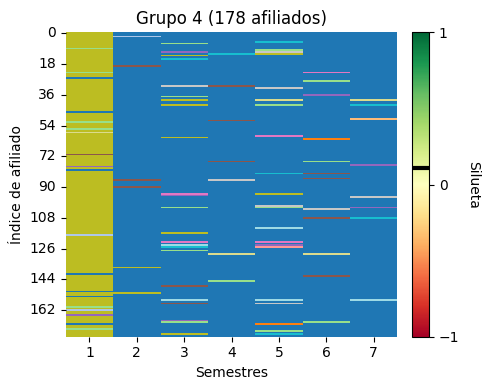

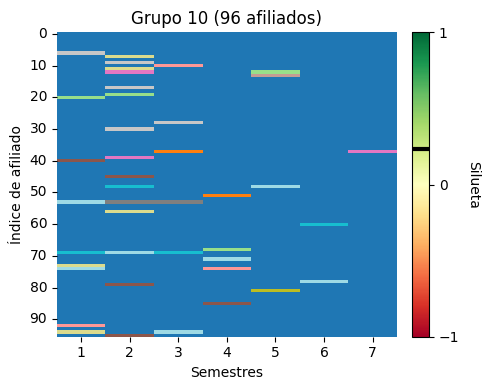

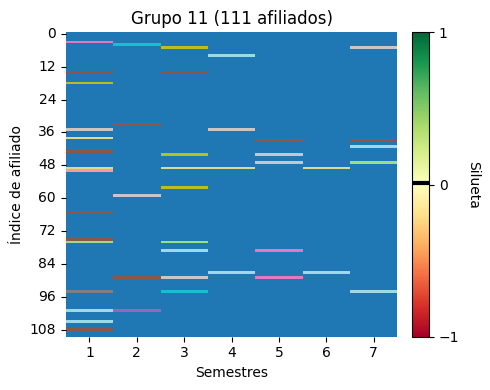

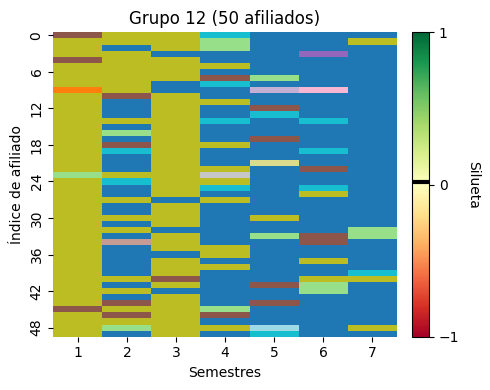

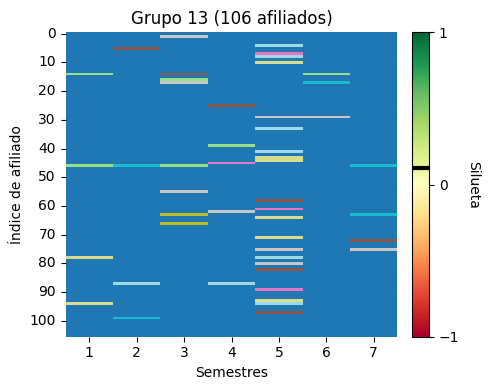

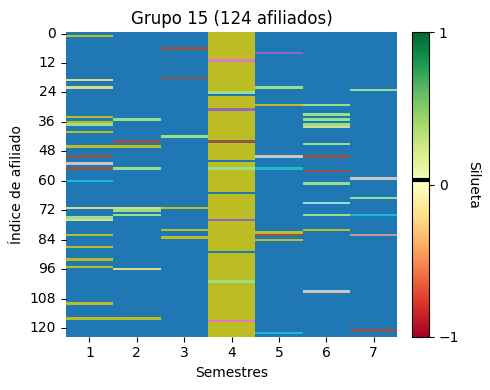

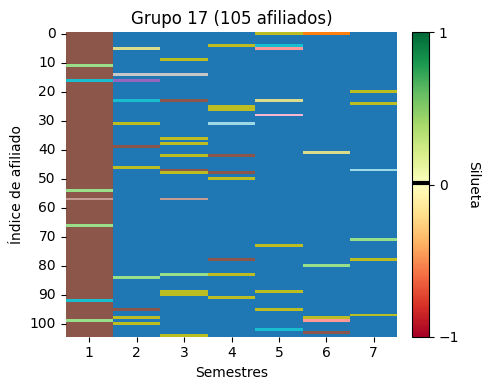

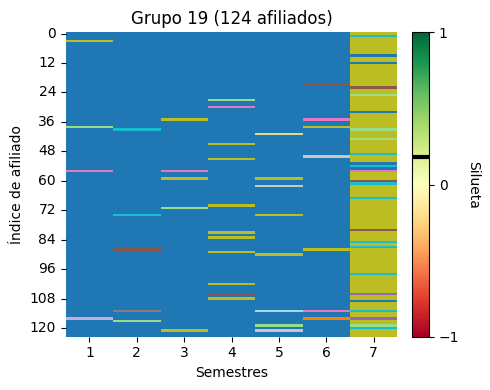

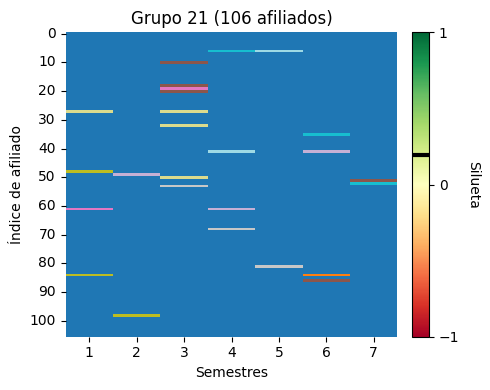

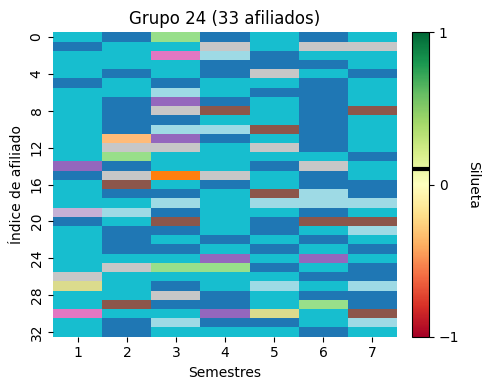

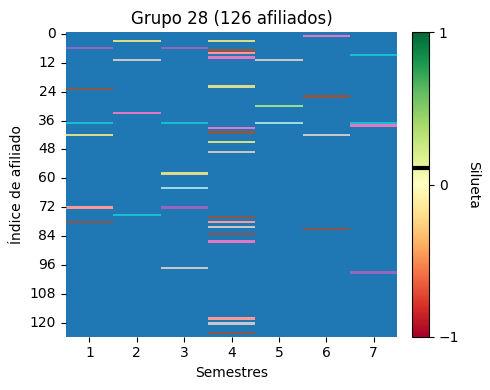

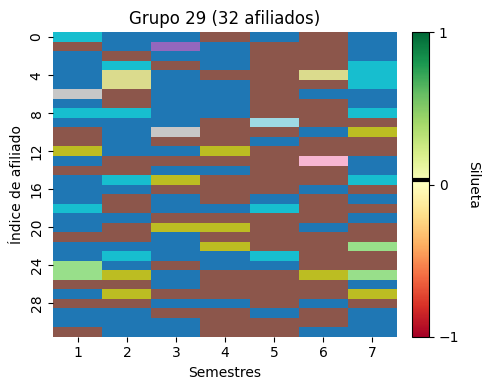

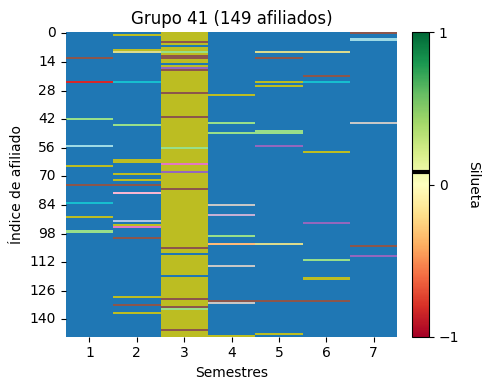

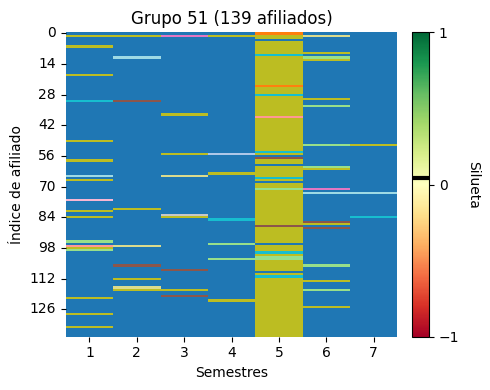

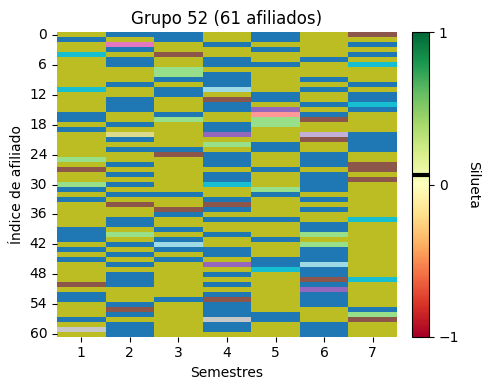

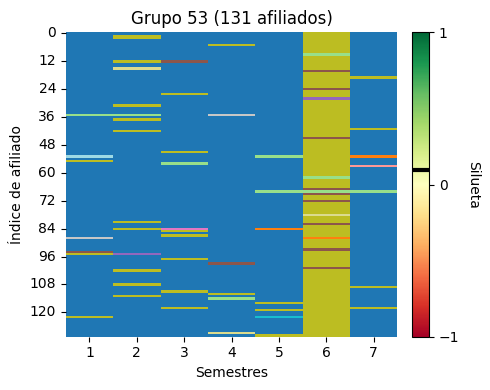

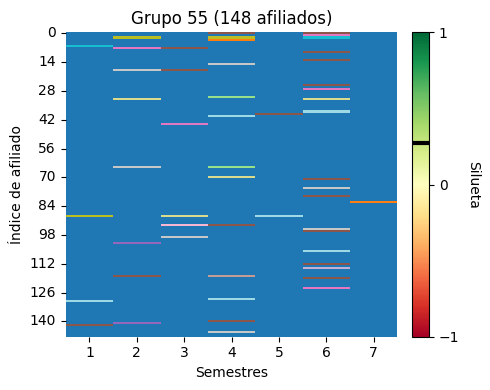

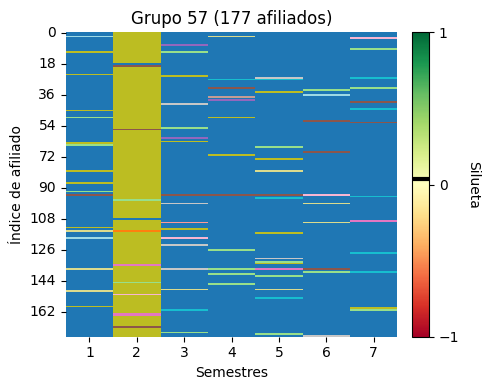

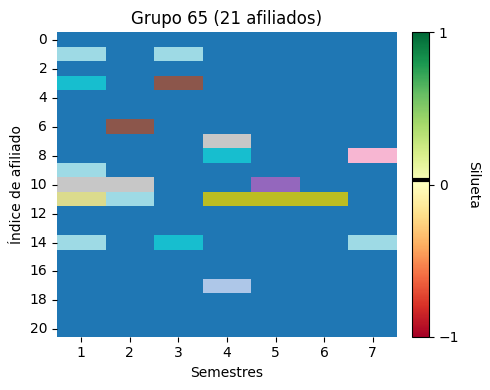

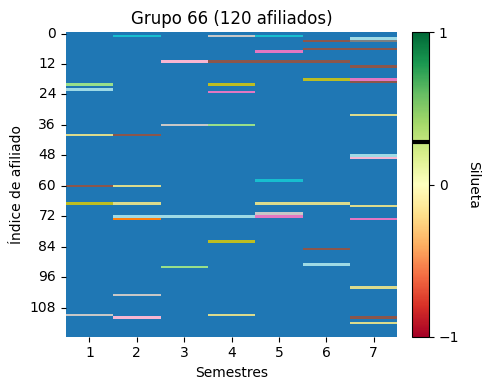

In [99]:
FILTER = True

for index_cluster,cluster_sil in zip(range(n_clusters),cluster_sil_vals):
    if FILTER and cluster_sil < 0:
        continue

    
    # create dataframe of the clusters
    df = pd.DataFrame(clusters[index_cluster], columns=[f'{i+1}' for i in range(num_semesters)])
    
    # suplots of figures
    fig, (ax_heatmap, ax_cbar) = plt.subplots(ncols=2, gridspec_kw={"width_ratios": [20, 1]}, figsize=(5, 4))
    
    # heatmap for seeing the sequences
    sns.heatmap(df, cmap="tab20", cbar=False, ax=ax_heatmap)
    
    # other
    ax_heatmap.set_title(f'Grupo {index_cluster+1} ({n_per_label[index_cluster]} afiliados)')
    ax_heatmap.set_xlabel('Semestres')
    ax_heatmap.set_ylabel('Índice de afiliado')

    # show labels intercalated
    yticks = ax_heatmap.get_yticks()
    yticks = yticks[::2]  
    ax_heatmap.set_yticks(yticks)

    
    # # the silhouette bar
    sm = plt.cm.ScalarMappable(cmap="RdYlGn", norm=plt.Normalize(vmin=-1, vmax=1))
    cbar = plt.colorbar(sm, cax=ax_cbar, ticks=[-1, 0, 1])
    cbar.set_label('Silueta', rotation=270, labelpad=15)
    ax_cbar.axhline(y=cluster_sil, color='black', linewidth=3)  
    plt.tight_layout()
    plt.show()

# PARA ANTO

Entender como funciona los SHAP values y ver como podemos usarlo para agregar explicabilidad al clustering. Ver si realmente nos sirve para sequence clustering.

que es shap values?: https://www.youtube.com/watch?v=MQ6fFDwjuco

como hacer explicable el clustering (post): https://towardsdatascience.com/how-to-make-clustering-explainable-1582390476cc

userguide de libreria de shap values: https://shap.readthedocs.io/en/latest/

github de la libreria: https://github.com/shap/shap